Époque 1/10 - Perte: 3.4965 | Validation: 3.4965 | Acc: 0.0300 / 0.0000
Époque 2/10 - Perte: 3.4965 | Validation: 3.4965 | Acc: 0.0600 / 0.0000
Époque 3/10 - Perte: 3.4964 | Validation: 3.4965 | Acc: 0.0600 / 0.0000
Époque 4/10 - Perte: 3.4963 | Validation: 3.4964 | Acc: 0.0600 / 0.0000
Époque 5/10 - Perte: 3.4963 | Validation: 3.4964 | Acc: 0.0600 / 0.0000
Époque 6/10 - Perte: 3.4962 | Validation: 3.4964 | Acc: 0.0600 / 0.0000
Époque 7/10 - Perte: 3.4962 | Validation: 3.4964 | Acc: 0.0600 / 0.0000
Époque 8/10 - Perte: 3.4961 | Validation: 3.4964 | Acc: 0.0600 / 0.0000
Époque 9/10 - Perte: 3.4961 | Validation: 3.4963 | Acc: 0.0600 / 0.0000
Époque 10/10 - Perte: 3.4960 | Validation: 3.4963 | Acc: 0.0600 / 0.0000


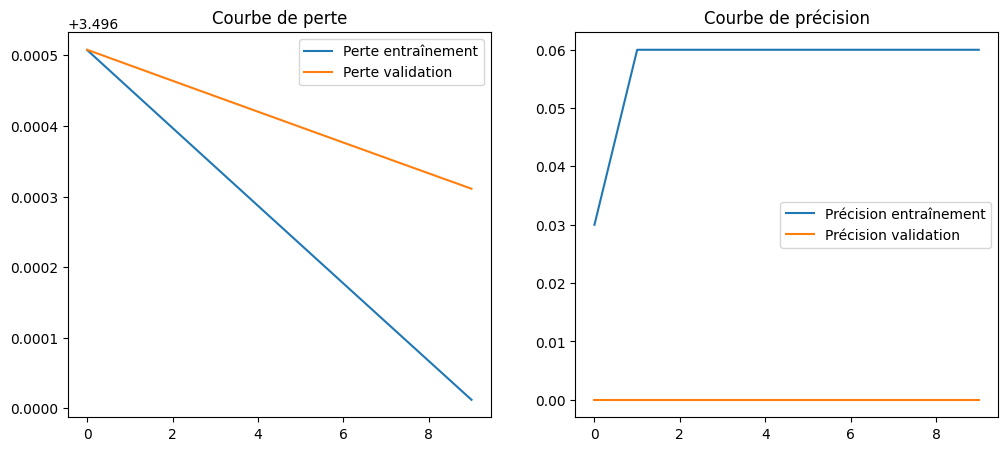

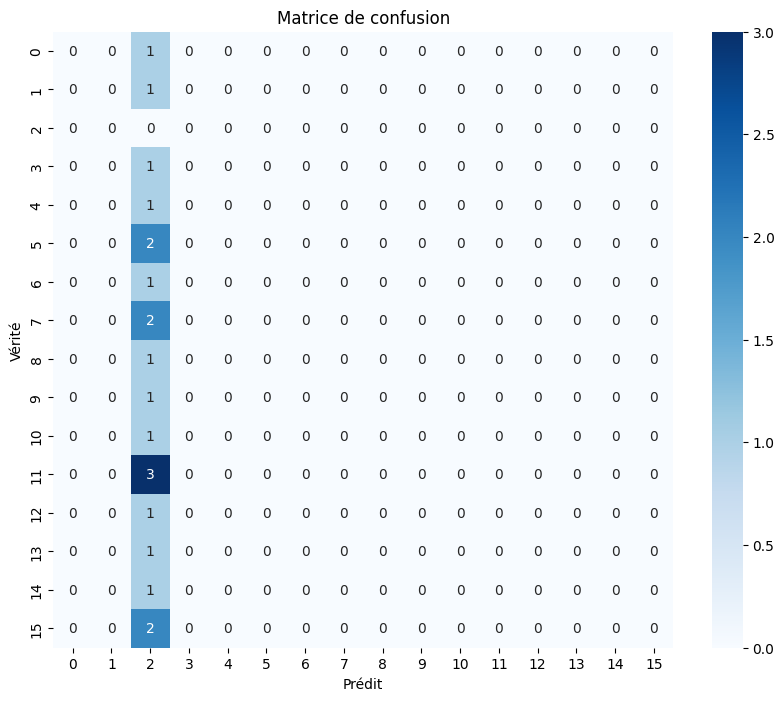

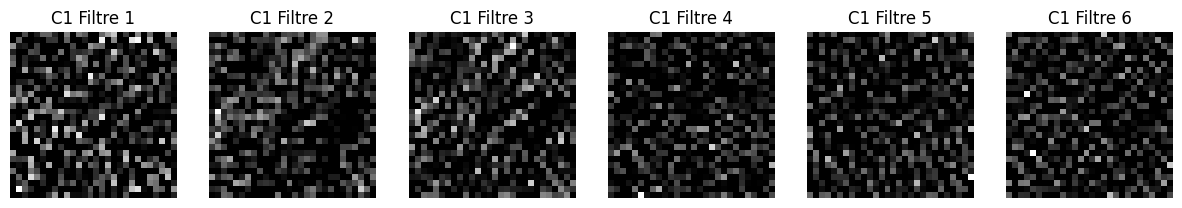

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# --- Fonctions d'activation ---
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # stabilité numérique
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# --- Initialisation des poids et biais ---
def initialize_weights():
    weights = {
        'C1': np.random.randn(6, 1, 5, 5) * 0.01,     # C1 : 6 filtres 5x5
        'C3': np.random.randn(16, 6, 5, 5) * 0.01,    # C3 : 16 filtres
        'C5': np.random.randn(120, 16, 5, 5) * 0.01,  # C5 : 120 filtres
        'F6': np.random.randn(120, 84) * 0.01,        # F6 : fully connected (120 -> 84)
        'out': np.random.randn(84, 33) * 0.01         # Sortie : 33 classes
    }
    biases = {
        'C1': np.zeros((6, 1)),
        'C3': np.zeros((16, 1)),
        'C5': np.zeros((120, 1)),
        'F6': np.zeros((84, 1)),
        'out': np.zeros((33, 1))
    }
    return weights, biases

# --- Convolution manuelle ---
def conv2d(input, filters, bias, stride=1, padding=0):
    n_filters, d_filter, h_filter, w_filter = filters.shape
    n, d, h, w = input.shape
    h_out = (h - h_filter + 2 * padding) // stride + 1
    w_out = (w - w_filter + 2 * padding) // stride + 1
    output = np.zeros((n, n_filters, h_out, w_out))
    
    # Ajout de padding si nécessaire
    input_padded = np.pad(input, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant') if padding > 0 else input

    # Calcul de la convolution
    for i in range(n):
        for f in range(n_filters):
            for j in range(h_out):
                for k in range(w_out):
                    region = input_padded[i, :, j*stride:j*stride+h_filter, k*stride:k*stride+w_filter]
                    output[i, f, j, k] = np.sum(region * filters[f] + bias[f])
    return output

# --- Pooling moyen (average pooling) ---
def avg_pooling(input, pool_size=2, stride=2):
    n, d, h, w = input.shape
    h_out = (h - pool_size) // stride + 1
    w_out = (w - pool_size) // stride + 1
    output = np.zeros((n, d, h_out, w_out))
    
    for i in range(n):
        for c in range(d):
            for j in range(h_out):
                for k in range(w_out):
                    output[i, c, j, k] = np.mean(input[i, c, j*stride:j*stride+pool_size, k*stride:k*stride+pool_size])
    return output

# --- Propagation avant (forward pass) ---
def forward(X, weights, biases):
    C1 = relu(conv2d(X, weights['C1'], biases['C1']))
    S2 = avg_pooling(C1)
    C3 = relu(conv2d(S2, weights['C3'], biases['C3']))
    S4 = avg_pooling(C3)
    C5 = relu(conv2d(S4, weights['C5'], biases['C5']))
    C5_flat = C5.reshape(C5.shape[0], -1)
    F6 = relu(np.dot(C5_flat, weights['F6']) + biases['F6'].T)
    out = np.dot(F6, weights['out']) + biases['out'].T
    probs = softmax(out)
    return probs, {'C1': C1, 'S2': S2, 'C3': C3, 'S4': S4, 'C5': C5, 'F6': F6, 'out': out}

# --- Fonction de coût (Cross-Entropy) ---
def cross_entropy_loss(probs, y):
    n = y.shape[0]
    log_probs = -np.log(probs[range(n), y])
    return np.mean(log_probs)

# --- Rétropropagation (partielle : couches fully connected uniquement) ---
def backward(X, y, probs, cache, weights, biases, lr=0.01):
    n = X.shape[0]
    d_out = probs.copy()
    d_out[range(n), y] -= 1
    d_out /= n

    dW_out = np.dot(cache['F6'].T, d_out)
    db_out = np.sum(d_out, axis=0, keepdims=True).T
    dF6 = np.dot(d_out, weights['out'].T) * relu_derivative(cache['F6'])

    dW_F6 = np.dot(cache['C5'].reshape(n, -1).T, dF6)
    db_F6 = np.sum(dF6, axis=0, keepdims=True).T

    weights['out'] -= lr * dW_out
    biases['out'] -= lr * db_out
    weights['F6'] -= lr * dW_F6
    biases['F6'] -= lr * db_F6

    return weights, biases

# --- Entraînement du modèle ---
def train(X_train, y_train, X_val, y_val, weights, biases, epochs=10, lr=0.01):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        probs, cache = forward(X_train, weights, biases)
        train_loss = cross_entropy_loss(probs, y_train)
        train_acc = np.mean(np.argmax(probs, axis=1) == y_train)

        val_probs, _ = forward(X_val, weights, biases)
        val_loss = cross_entropy_loss(val_probs, y_val)
        val_acc = np.mean(np.argmax(val_probs, axis=1) == y_val)

        weights, biases = backward(X_train, y_train, probs, cache, weights, biases, lr)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Époque {epoch+1}/{epochs} - Perte: {train_loss:.4f} | Validation: {val_loss:.4f} | Acc: {train_acc:.4f} / {val_acc:.4f}")

    return weights, biases, train_losses, val_losses, train_accs, val_accs

# --- Visualisation des résultats ---
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Perte entraînement')
    plt.plot(val_losses, label='Perte validation')
    plt.legend()
    plt.title('Courbe de perte')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Précision entraînement')
    plt.plot(val_accs, label='Précision validation')
    plt.legend()
    plt.title('Courbe de précision')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Prédit")
    plt.ylabel("Vérité")
    plt.title("Matrice de confusion")
    plt.show()

def plot_feature_maps(feature_maps, layer_name, num_filters=6):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_filters, feature_maps.shape[1])):
        plt.subplot(1, num_filters, i+1)
        plt.imshow(feature_maps[0, i], cmap='gray')
        plt.axis('off')
        plt.title(f'{layer_name} Filtre {i+1}')
    plt.show()

# --- Simulation des données ---
X_train = np.random.randn(100, 1, 32, 32)
y_train = np.random.randint(0, 33, 100)
X_val = np.random.randn(20, 1, 32, 32)
y_val = np.random.randint(0, 33, 20)

# --- Exécution ---
weights, biases = initialize_weights()
weights, biases, train_losses, val_losses, train_accs, val_accs = train(X_train, y_train, X_val, y_val, weights, biases)

plot_curves(train_losses, val_losses, train_accs, val_accs)

probs, _ = forward(X_val, weights, biases)
y_pred = np.argmax(probs, axis=1)
plot_confusion_matrix(y_val, y_pred)

_, cache = forward(X_val[:1], weights, biases)
plot_feature_maps(cache['C1'], 'C1', num_filters=6)
